# Dashboard of  experiments in post silicon for WL affinity (SKX) SPEC 17

In [2]:
%matplotlib inline

import os
from pca.pca import *
from clustering.distortion import *
from clustering.clustering import *
from clustering.cluster_score import *

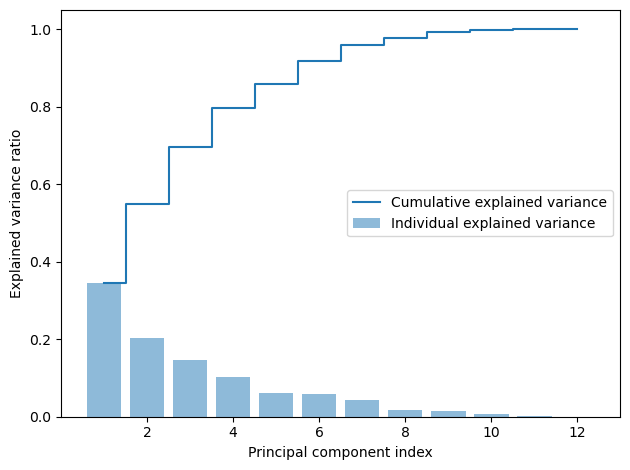

,principal component 1,principal component 2,test_name
0,2.725556,-0.384197,654.roms
1,-1.853516,-0.327353,625.x264
2,0.827516,0.468315,628.pop2
3,1.352494,0.043497,649.fotonik3d
4,-1.737347,1.164917,620.omnetpp
5,4.216863,-1.382696,619.lbm
6,-2.745553,-0.397913,641.leela
7,-1.641430,-0.578703,648.exchange2
8,0.639802,-0.791599,627.cam4
9,-1.793819,-0.375358,657.xz


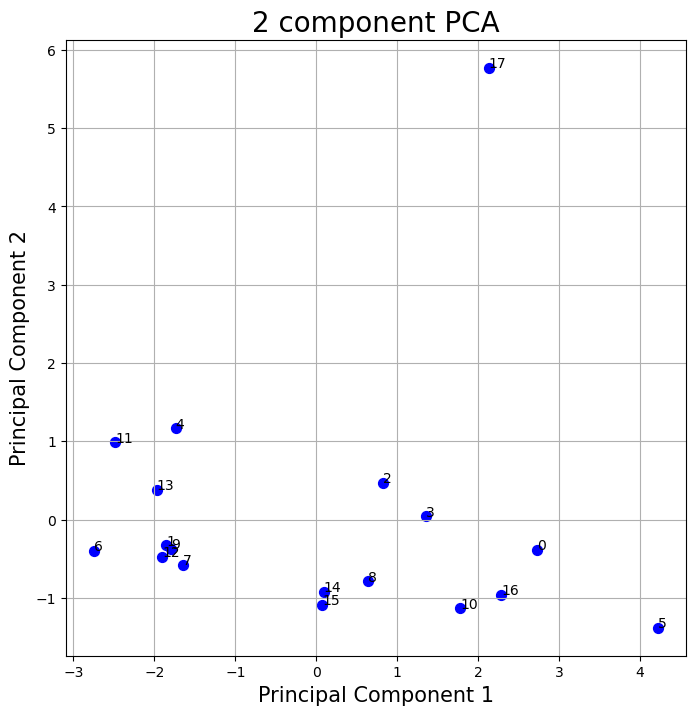

In [4]:
filename = 'post_silicon/summary.csv'
pca_df = None

if os.path.exists(filename):
    df = pd.read_csv(filename)
    df.fillna(0,inplace=True)

    features = list(df.columns)[1:]
    test_column = list(df.columns)[0]
    
    #pca_df,eig_vals,eig_vecs = get_PCA(df, features, test_column)
    pca_df = get_PCA(df,features)
    x = get_features(df,features)
    X_std = StandardScaler().fit_transform(x)
    exp_var_pca = get_explained_variance(X_std)
    plot_explained_variance(exp_var_pca)
    plot_PCA(pca_df)
    display(pca_df)

else:
    print("Filename error")

#display(eig_vals)
#display(eig_vecs)

# Plot characteristics of the worklaods

In [8]:
if os.path.exists("pca.csv"):    
    clusters = calculate_elbow(pd.read_csv("pca.csv"))


In [10]:
print(f'Optimal number of clusters = {clusters[0]}')

Optimal number of clusters = 3


## Clasification based on optimal number of clusters

In [6]:
df_result,kmeans = kmean_cluster("pca.csv",clusters)
df_result

pca.csv


TypeError: string indices must be integers

# Get the test cases closer to centroid

In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min
X = pd.read_csv("pca.csv", usecols = ['principal component 1','principal component 2'])
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
pca_df = pd.read_csv("pca.csv")
df = pca_df.iloc[closest]
df

In [ ]:
list_tests = df['test_name'].tolist()
df_global = pd.read_csv(filename)
df2 = df_global[df_global['test_name'].isin(list_tests)]
df2.plot.barh(x="test_name")
df2


## Clasification based on FP/INT clusters


In [ ]:
df_result,kmeans = kmean_cluster("pca.csv",2)
df_result

## Automatic label of clusters based cosine similarity to FP/INT


\begin{equation}
\cos ({\bf t},{\bf e})= {{\bf t} {\bf e} \over \|{\bf t}\| \|{\bf e}\|} = \frac{ \sum_{i=1}^{n}{{\bf t}_i{\bf e}_i} }{ \sqrt{\sum_{i=1}^{n}{({\bf t}_i)^2}} \sqrt{\sum_{i=1}^{n}{({\bf e}_i)^2}} }
\end{equation}

In [ ]:
df = pd.read_csv("references/clusters_spec2017_clean.csv")
print(df)
df_sorted = df.sort_values(by='REAL')
fp_tests = df_sorted[df_sorted['REAL'] == 0]
int_tests = df_sorted[df_sorted['REAL'] == 1]

df = pd.read_csv("clusters.csv")
print(df)
df_sorted = df.sort_values(by='PRED')
A = df_sorted[df_sorted['PRED'] == 0]
B = df_sorted[df_sorted['PRED'] == 1]

C = normalize(A,B,fp_tests,int_tests)
C_sorted =  C.sort_values(by='test_name', ascending=False)

REAL = pd.read_csv("references/clusters_spec2017_clean.csv")
REAL_sorted = REAL.sort_values(by='test_name', ascending=False)

labels_pred = C_sorted["PRED"].tolist()
labels_pred_ = [eval(i) for i in labels_pred]
labels_pred = labels_pred_

labels_true = REAL_sorted["REAL"].tolist()


df = pd.DataFrame({'labels':C_sorted['test_name'], 'val_pred':labels_pred, 'val_true':labels_true})

print()
print(df)

print()
print(df.loc[~(df['val_pred'] == df['val_true'])])


ax = df.plot.barh(x='labels', y=['val_pred','val_true'],  rot=0, title= "Cluster 0: FP / 1: INT")


scores_result = scores(labels_true,labels_pred)

df = pd.DataFrame({'scores':['adjusted_rand_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score'], 'val':scores_result[:-1]})
ax = df.plot.barh(x='scores', y='val', rot=0, title= "Scores (HIB)")